# Collect & explore data about the recent pandemic from Twitter

### Connect to Twitter 


In [2]:
import tweepy
from twitter_config import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
auth = tweepy.OAuthHandler(config['api_key'], config['api_secret_key'])
auth.set_access_token(config['access_token'], config['access_token_secret'])

api = tweepy.API(auth)

# api.get_user(screen_name='twitter')

### Collect data by building a stream
* Create a stream listener.
* Monitor the given COVID-19 related terms. 
* Collect 50k statuses and save to a list called covid_tweets.

In [3]:
terms = ['covid19', '#ncov2019', 'Covid_19', '#conronaviruspandemic', 'COVID-19', '#caronavirus', 
         '#infocoronavirus', 'coronavirusupdate', 'carona virus', '#coronavirues', '#Coronovirus', 
         '#2019nCoV', '#Coronvirus', '#Coronavirus', 'covid-19', 'Coronavirus', '#caronavirusoutbreak', 
         'covid', '#CoronaVirusUpdate', '#Corvid19virus', '#covid', 'coronavirus', '#CoronaVirus', 'nCoV', 
         'covid 19', '#nCoV2019', '#covid_19', '#coronavirusupdates', '#COVIDー19', '#2019nCov', '#CoronaAlert', 
         '#coronavirus', 'SARS-CoV-2', '#nCoV', '#coronanews', '#COVID', '2019nCoV', '#CoronavirusOutbreak', 
         '#coronapocolypse', '#COVID19', '#codvid19', '#codvid_19', 'coronavirus outbreak']

In [4]:
class MyStreamListener(tweepy.StreamListener):
    '''
    Extends the 'tweepy.StreamListener' class and overrides the 'on_status' method
    in order to store tweets to the member list '_covid_tweets'
    '''
    
    def __init__(self, num_of_items):
        super(MyStreamListener, self).__init__()
        self._count = 0
        self._covid_tweets = []
        self._num_of_items = num_of_items
    
    def on_status(self, status):
        self._count += 1
        self._covid_tweets.append(status)
        
        if self._count == self._num_of_items:
            # Disconnect the stream
            return False
        
    def on_error(self, status_code):
        # If a number of attempts to connect to the streaming API has been exceeded
        if status_code == 420:
            return False
    
    @property
    def count(self):
        return self._count
    
    @property
    def covid_tweets(self):
        return self._covid_tweets
    
    @property
    def num_of_items(self):
        return _num_of_items
    
    @num_of_items.setter
    def num_of_items(value):
        self._num_of_items = value


In [5]:
# Initialise the stream using our StreamListener
num_of_tweets = 50000
myStreamListener = MyStreamListener(num_of_tweets)
stream = tweepy.Stream(auth = api.auth, listener=myStreamListener)

In [6]:
%%time
# Start tracking terms
stream.filter(track=terms)

Wall time: 17min 21s


In [7]:
# Access the tweets as a property of our implementation of the listener and store them to a python list
covid_tweets = myStreamListener.covid_tweets

In [8]:
# Let's inspect the list of attributes a tweet contains
covid_tweets[0]._json.keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status', 'quoted_status_permalink', 'is_quote_status', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted', 'filter_level', 'lang', 'timestamp_ms'])

In [9]:
len(covid_tweets)

50000

### Create a dataframe
* Put all the collected tweets in a dataframe.
* As columns of the dataframe keep only the following attributes: `created_at`, `place`, `lang` and `text`. Also, the `screen_name`, `followers_count`, `statuses_count`, and `location` of the `user`.  
* Make sure that any column with dates is treated as such by the dataframe.

In [12]:
# Read the data from the json file and save them to temporary lists 
dates, places, langs, texts, users, followers_count, statuses_count, locations = [], [], [], [], [], [], [], []
for tweet in covid_tweets:
    dates.append(tweet._json["created_at"])
    places.append(tweet._json["place"])
    langs.append(tweet._json["lang"])
    texts.append(tweet._json["text"])

    users.append(tweet._json["user"]["screen_name"])
    followers_count.append(tweet._json["user"]["followers_count"])
    statuses_count.append(tweet._json["user"]["statuses_count"])
    locations.append(tweet._json["user"]["location"])



In [13]:
# Store the data to a Pandas DataFrame and delete the temporary lists for memory efficiency
df = pd.DataFrame({"date":dates, "place":places, "lang":langs, "text":texts, "user":users,
                     "followers_count":followers_count, "statuses_count":statuses_count, "location": locations})

del dates, places, langs, texts, users, followers_count, statuses_count, locations
df.head()

,date,place,lang,text,user,followers_count,statuses_count,location
0,Wed Oct 28 12:29:10 +0000 2020,None,en,"RT @rais_shk: Modi Ji,\nThe Ministry of Electr...",FayazSafoora,60,3245,None
1,Wed Oct 28 12:29:10 +0000 2020,None,en,$Gold dips on stronger $dollar; #coronavirus c...,GrantOnGold,4366,38553,"Denver, Colorado USA"
2,Wed Oct 28 12:29:10 +0000 2020,None,es,RT @VillaFernando_: América Latina registra un...,Keyra2,261,18602,Portoviejo
3,Wed Oct 28 12:29:10 +0000 2020,None,de,In der aktuellen Folge unseres Podcasts sprech...,ibe_lu,56,99,Ludwigshafen am Rhein
4,Wed Oct 28 12:29:10 +0000 2020,None,fr,RT @daime4l: La poukave du quartier gouverneme...,yayvx,948,6819,Fox river


In [10]:
# Make Pandas recognize the "date" column as a Datetime object
df.date = pd.to_datetime(df.date, infer_datetime_format=True)
df.head()

,Unnamed: 0,date,place,lang,text,user,followers_count,statuses_count,location
0,0,2020-10-28 12:29:10,NaN,en,"RT @rais_shk: Modi Ji,\nThe Ministry of Electr...",FayazSafoora,60,3245,NaN
1,1,2020-10-28 12:29:10,NaN,en,$Gold dips on stronger $dollar; #coronavirus c...,GrantOnGold,4366,38553,"Denver, Colorado USA"
2,2,2020-10-28 12:29:10,NaN,es,RT @VillaFernando_: América Latina registra un...,Keyra2,261,18602,Portoviejo
3,3,2020-10-28 12:29:10,NaN,de,In der aktuellen Folge unseres Podcasts sprech...,ibe_lu,56,99,Ludwigshafen am Rhein
4,4,2020-10-28 12:29:10,NaN,fr,RT @daime4l: La poukave du quartier gouverneme...,yayvx,948,6819,Fox river


In [15]:
# Save the dataframe into a csv file for future usage
# df.to_csv('covid.csv')

### Exploratory analysis
* Report the number of unique: users, locations, and users mentioned within the tweets.
* How many tweets (%) had their place attribute empty.
* Plot the distribution of languages (barplot).
* Plot the number of tweets per minute, from the minute of the first to the minute of the last tweet that was collected (hint: use `dt`).
* Plot the number of tweets per minute for the 3 most frequently mentioned places. Discriminating between the three (e.g., using hue) is preferred but not requested.

In [16]:
print(f"Number of unique users: {len(df.user.unique())}")
print(f"Number of unique locations: {len(df.location.unique())}")

Number of unique users: 41470
Number of unique locations: 14133


In [65]:
# Parts of this code cell taken from lectures' slides
import re
# A regex for extracting user mentions (e.g. @user)
p = re.compile('@[\w\-.]+')
# Concatenate all texts for all the tweets
all_texts = " ".join(df.text.to_list())
users_mentioned = p.findall(all_texts)
# Use set data structure to maintain only unique usernames
print(f"Number of unique users mentioned: {len(set(users_mentioned))}")

Number of unique users mentioned: 16126


In [18]:
print(f"Percentage of tweets that had their place attribute empty: {df.place.isnull().sum() / len(df) * 100} %")

Percentage of tweets that had their place attribute empty: 99.09 %


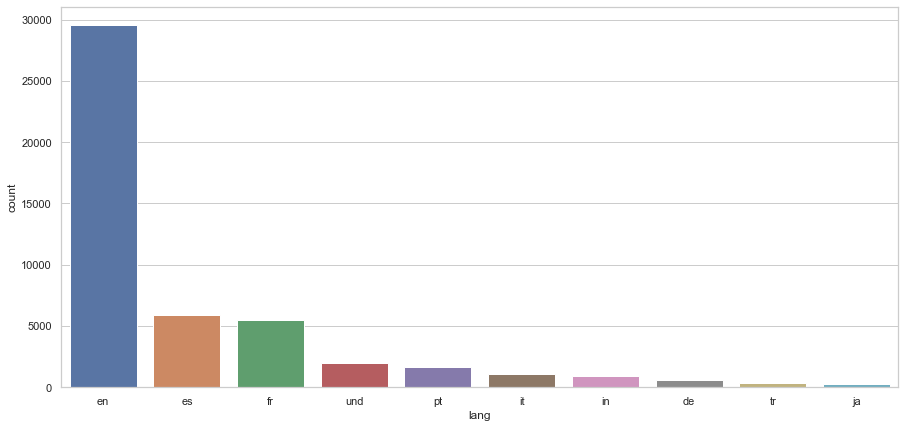

In [133]:
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,7))
# We select to plot the 10 most common languages as the count for the rest of them is negligible
ax = sns.countplot(x="lang", data=df, order=df.lang.value_counts().index[:10])

In [14]:
# We make a grouping based on the minute every tweet was created at and make an aggregation count on the records
# df.groupby([df.date.dt.minute]).agg({'date': 'count'})
df.groupby([df.date.dt.minute]).count().date

date
29    2248
30    2870
31    2757
32    2756
33    2743
34    2758
35    2859
36    2987
37    2943
38    2936
39    2941
40    2944
41    2936
42    2954
43    2959
44    2932
45    2967
46    1510
Name: date, dtype: int64

In [3]:
df = pd.read_csv('covid.csv')

In [5]:
df.date

0        2020-10-28 12:29:10
1        2020-10-28 12:29:10
2        2020-10-28 12:29:10
3        2020-10-28 12:29:10
4        2020-10-28 12:29:10
                ...         
49995    2020-10-28 12:46:31
49996    2020-10-28 12:46:31
49997    2020-10-28 12:46:31
49998    2020-10-28 12:46:31
49999    2020-10-28 12:46:31
Name: date, Length: 50000, dtype: object

We can either use a __Countplot__ using the Seaborn package or a __Lineplot__ using Pandas interior functionality.

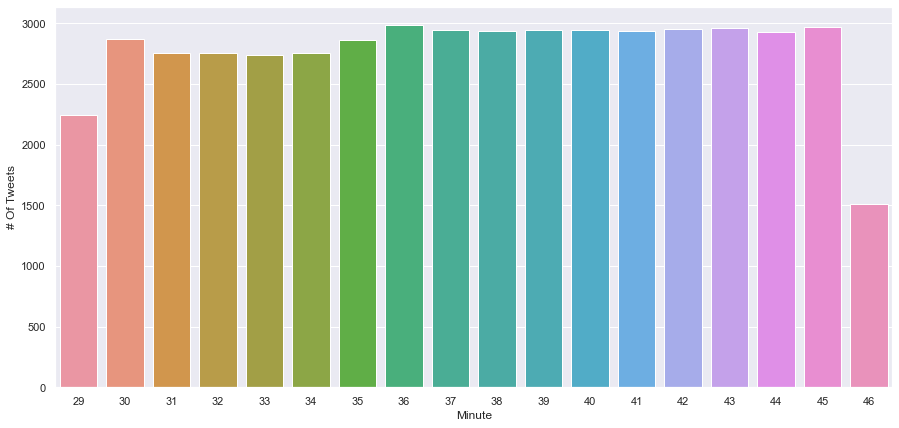

<Figure size 1080x504 with 0 Axes>

In [243]:
ax = sns.countplot(x=df.date.dt.minute)
plt.figure(figsize=(15,7))
_ = ax.set(xlabel='Minute', ylabel='# Of Tweets')

<AxesSubplot:xlabel='minute', ylabel='Tweets'>

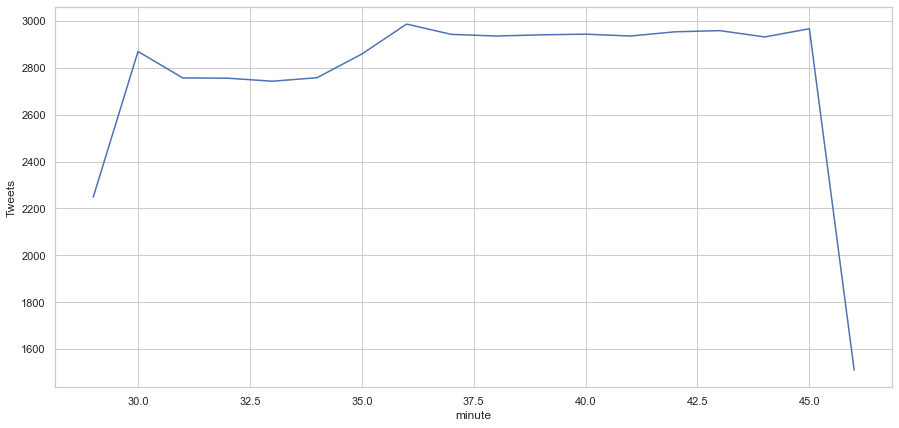

In [135]:
df.groupby([df.date.dt.minute]).agg({'date': 'count'}).plot(xlabel="minute", ylabel="Tweets", legend=None, figsize=(15, 7))
# Alternatively
# df.resample('1T', on='date').agg({'date': 'count'}).plot(figsize=(15, 7))

In [35]:
# Print the 3 most common locations
print(df.location.value_counts().iloc[:3].keys())

Index(['United States', 'France', 'USA'], dtype='object')


In [152]:
# Put them in a list
top_3_locations = [location for location in df.location.value_counts().iloc[:3].keys()]

# Create a new DataFrame containing only the records we are interested in
df_top3 = df[df.location.isin(top_3_locations)]

In [271]:
# We perform a double groupby using two features
df_top3.groupby([df_top3.date.dt.minute, 'location']).agg({'date': 'count'}).T

date         29                       30                       31      \
location France USA United States France USA United States France USA   
date         17   7            14     25  10            29     21  17   

date                       32  ...            43     44                    \
location United States France  ... United States France USA United States   
date                25     19  ...            36     17  13            41   

date         45                       46                    
location France USA United States France USA United States  
date         14  13            28      5   5            18  

[1 rows x 54 columns]

Here again, we could use either Seaborn or Pandas plotting.

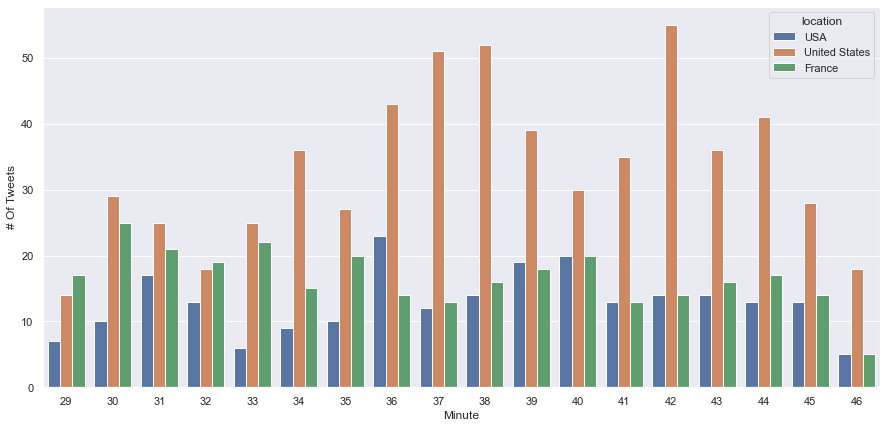

<Figure size 1080x504 with 0 Axes>

In [252]:
ax = sns.countplot(x=df_top3.date.dt.minute, hue=df_top3.location)
plt.figure(figsize=(15,7))
_ = ax.set(xlabel='Minute', ylabel='# Of Tweets')

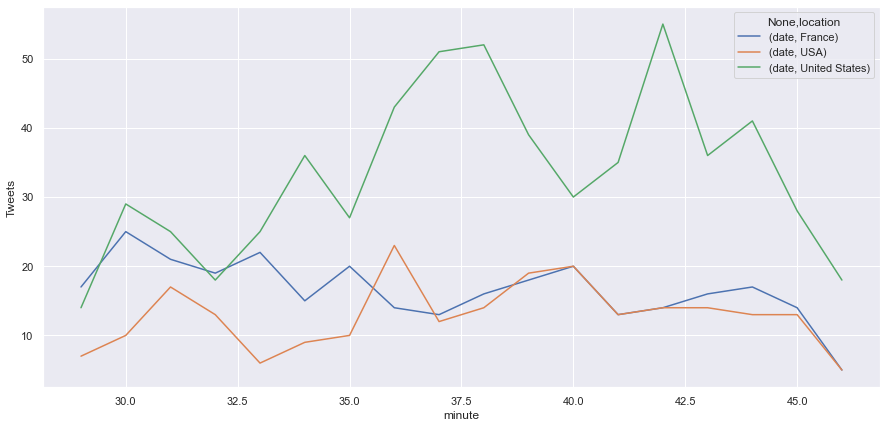

In [253]:
_ = df_top3.groupby([df_top3.date.dt.minute, 'location']).agg({'date': 'count'}).unstack() \
        .plot(xlabel="minute", ylabel="Tweets", figsize=(15,7))

### Filtering
* Assume that simple emoticons can capture the sentiment of a tweet.
* Create one regular expression to detect positive emoticons: `:)`,`:D`, `XD` and one to detect negative emoticons: `:(`, `:'(`, `:((` in the tweets. Report the number of tweets with positive and the number of tweets with negative sentiment.
* Plot the number of tweets with positive and the number of tweets with negative sentiment per minute.

In [163]:
positive_regex = r'[xX:][)D]+' # Starts with one of: 'x', 'X', ':' followed by one or more ')' or 'D'
negative_regex = r':\'?\(+' # # Starts with ':' followed by zero or one "tear" and finally one or more '('

In [164]:
n_pos_comments = len(df[df.text.str.contains(positive_regex)])
n_neg_comments = len(df[df.text.str.contains(negative_regex)])

In [256]:
print(f"Number of tweets with positive sentiment: {n_pos_comments}\n\
Number of tweets with negative sentiment: {n_neg_comments}")

Number of tweets with positive sentiment: 95
Number of tweets with negative sentiment: 27


In [265]:
# Create a new DataFrame containing only tweets with positive or negative sentiment
emotions_df = df[(df.text.str.contains(positive_regex)) | (df.text.str.contains(negative_regex))]
# Here, we abusively suppose that a record which has simultaneously positive and negative sentiment,
# is classified as positive, with small error rate
emotions_df["positive_emotion"] = emotions_df.text.str.contains(positive_regex)

<ipython-input-265-7f5f18c7dd91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotions_df["positive_emotion"] = emotions_df.text.str.contains(positive_regex)


In [257]:
emotions_df.positive_emotion.value_counts()

True     95
False    27
Name: positive_emotion, dtype: int64

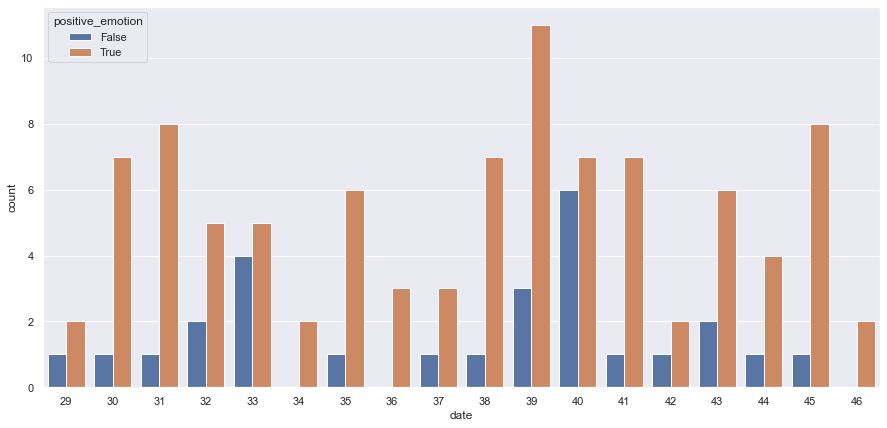

In [259]:
ax = sns.countplot(x=emotions_df.date.dt.minute, hue=emotions_df.positive_emotion)

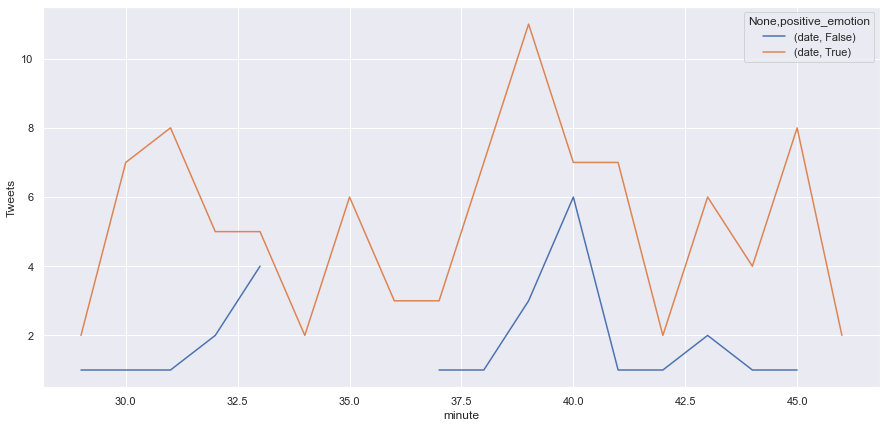

In [261]:
_ = emotions_df.groupby([emotions_df.date.dt.minute, 'positive_emotion']).agg({'date': 'count'}).unstack() \
        .plot(xlabel="minute", ylabel="Tweets", figsize=(15,7))

### Text pre-processing
Use regular expressions to remove:
* Punctuation
* Digits
* New line characters
* URL links
* References to users: `@user`
* Hashtags

In order to avoid information leaks, we should be careful about the ordering of the asked procedures. So, we should firstly remove URL links and references to other users, then hashtags, digits and new lines and finally punctuation. Additionally, we will print the text of the first tweet indicativelly, after every transformation.

In [231]:
print(df.iloc[0].text)

RT @rais_shk: Modi Ji,
The Ministry of Electronic, NIC &amp; NeGD has no information about who &amp; how created the #ArogyaSethuApp.
Can you tell…


In [267]:
# Remove URLs - Starts with 'http' followed by zero or one 's', then :// followed by any non whitespace character
df["clean_text"] = df.text.replace(r'https?://\S+', "", regex=True)
print(df.iloc[0].clean_text)

# Remove user mentions - Starts with a '@' followed by alpharithmetical or '-' or '.' one or more times
df.clean_text = df.clean_text.replace(r'@[\w\-.]+', "", regex=True)
print(df.iloc[0].clean_text)

# Remove hashtags - Starts with a '#' followed by any non whitespace character
df.clean_text = df.clean_text.replace(r'#\S+', "", regex=True)
print(df.iloc[0].clean_text)

# Remove digits - Self explanatory
df.clean_text = df.clean_text.replace(r'\d', "", regex=True)
print(df.iloc[0].clean_text)

# Remove new line characters - Self explanatory
df.clean_text = df.clean_text.replace(r'\n', "", regex=True)
print(df.iloc[0].clean_text)

RT @rais_shk: Modi Ji,
The Ministry of Electronic, NIC &amp; NeGD has no information about who &amp; how created the #ArogyaSethuApp.
Can you tell…
RT : Modi Ji,
The Ministry of Electronic, NIC &amp; NeGD has no information about who &amp; how created the #ArogyaSethuApp.
Can you tell…
RT : Modi Ji,
The Ministry of Electronic, NIC &amp; NeGD has no information about who &amp; how created the 
Can you tell…
RT : Modi Ji,
The Ministry of Electronic, NIC &amp; NeGD has no information about who &amp; how created the 
Can you tell…
RT : Modi Ji,The Ministry of Electronic, NIC &amp; NeGD has no information about who &amp; how created the Can you tell…


In [268]:
from string import punctuation

print(punctuation, '\n')
# Finally, remove punctuation - Used the 'punctuation' module from the 'string' package
df.clean_text = df.clean_text.replace(f"[{punctuation}]", "", regex=True)
print(df.iloc[0].clean_text)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 

RT  Modi JiThe Ministry of Electronic NIC amp NeGD has no information about who amp how created the Can you tell…


In [237]:
df

,date,place,lang,text,user,followers_count,statuses_count,location,clean_text
0,2020-10-28 12:29:10,None,en,"RT @rais_shk: Modi Ji,\nThe Ministry of Electr...",FayazSafoora,60,3245,None,"RT : Modi Ji,The Ministry of Electronic, NIC &..."
1,2020-10-28 12:29:10,None,en,$Gold dips on stronger $dollar; #coronavirus c...,GrantOnGold,4366,38553,"Denver, Colorado USA",$Gold dips on stronger $dollar; concerns cap ...
2,2020-10-28 12:29:10,None,es,RT @VillaFernando_: América Latina registra un...,Keyra2,261,18602,Portoviejo,RT : América Latina registra un récord históri...
3,2020-10-28 12:29:10,None,de,In der aktuellen Folge unseres Podcasts sprech...,ibe_lu,56,99,Ludwigshafen am Rhein,In der aktuellen Folge unseres Podcasts sprech...
4,2020-10-28 12:29:10,None,fr,RT @daime4l: La poukave du quartier gouverneme...,yayvx,948,6819,Fox river,RT : La poukave du quartier gouvernemental
...,...,...,...,...,...,...,...,...,...
49995,2020-10-28 12:46:31,None,en,RT @steve_vladeck: Trump literally left his su...,PhyllisWykoff,57,120,None,RT : Trump literally left his supporters out i...
49996,2020-10-28 12:46:31,None,und,RT @MrsQuaye: #COVID19 #WednesdayWisdom https:...,judecco,478,83864,"Ealing, London",RT :
49997,2020-10-28 12:46:31,None,en,RT @UtFacio: @momsbsm1 @kim_kwasRN So MAGA vot...,StephStanton3,423,10734,None,RT : So MAGA voters will be the ones stuck i...
49998,2020-10-28 12:46:31,None,es,RT @GNB43_Capital: 🚨🖇️#26Oct || Efectivos .@GN...,3raD452,18,632,None,RT : 🚨🖇️ || Efectivos .realizaron patrullaje M...
